Rossiter-McLaughlin Effect
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.2 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.2,<2.3"

In [1]:
%matplotlib inline

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.ipynb) for more details.

In [1]:
import phoebe
import numpy as np

b = phoebe.default_binary()

Let's make a significant mass ratio and radius ratio and spin up the primary star.

In [2]:
b.set_value('q', value=0.7)
b.set_value('incl', component='binary', value=87)
b.set_value('requiv', component='primary', value=0.75)
b.set_value('teff', component='secondary', value=6500)
b.set_value('syncpar', component='secondary', value=1.3)

Adding Datasets
-------------------

Now we'll add radial velocity, line profile, and mesh datasets.  We'll compute the rvs through the whole orbit, but the mesh and line profiles just at the times that we want to plot for an animation (which we'll do by concatenating three arrays so the animation "slow down" during eclipse).

In [3]:
anim_times= np.concatenate((np.linspace(0.4, 0.48, 21), 
                            np.linspace(0.48, 0.52, 21), 
                            np.linspace(0.52, 0.6, 21)))

We'll add two identical datasets, one where we compute only dynamical RVs (won't include Rossiter-McLaughlin) and another where we compute flux-weighted RVs (will include Rossiter-McLaughlin).

In [4]:
b.add_dataset('rv', 
              times=phoebe.linspace(0,1,101), 
              dataset='dynamicalrvs')

b.set_value_all('rv_method', dataset='dynamicalrvs', value='dynamical')

In [5]:
b.add_dataset('rv', 
              times=phoebe.linspace(0,1,101), 
              dataset='numericalrvs')

b.set_value_all('rv_method', dataset='numericalrvs', value='flux-weighted')

For the mesh, we'll save some time by only exposing plane-of-sky coordinates and the 'rvs' column.

In [6]:
b.add_dataset('mesh', 
              compute_times=anim_times, 
              coordinates='uvw', 
              columns=['rvs@numericalrvs'],
              dataset='mesh01')

<ParameterSet: 7 parameters | contexts: dataset, compute, constraint>

And for the line-profile, we'll expose the line-profile for both of our stars separately, instead of for the entire system.

In [7]:
b.add_dataset('lp', 
              compute_times=anim_times, 
              component=['primary', 'secondary'], 
              wavelengths=phoebe.linspace(549.5,550.5,101), 
              profile_rest=550)

<ParameterSet: 14 parameters | contexts: dataset, compute, constraint>

Running Compute
--------------------

In [8]:
b.run_compute(irrad_method='none')

<ParameterSet: 500 parameters | kinds: rv, mesh, lp>

Plotting 
---------------

First let's compare between the dynamical and numerical RVs.

The dynamical RVs show the velocity of the center of each star along the line of sight.  But the numerical method integrates over the visible surface elements, giving us what we'd observe if deriving RVs from observed spectra of the binary.  Here we do see the Rossiter McLaughlin effect.  You'll also notice that RVs are not available for the secondary star when its completely occulted (they're nans in the array).

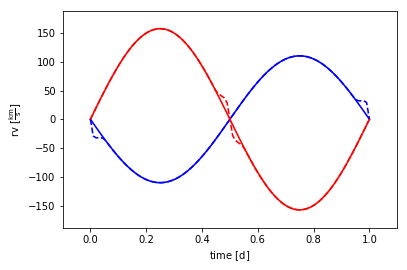

In [9]:
afig, mplfig = b.plot(kind='rv',
                      c={'primary': 'b', 'secondary': 'r'}, 
                      ls={'numericalrvs': 'dashed', 'dynamicalrvs': 'solid'},
                      show=True)

We'll remove the dynamical RVs entirely since we don't want to include them from here on out.

In [10]:
#b.remove_dataset('dynamicalrvs')

Now let's make a plot of the line profiles and mesh during ingress to visualize what's happening.  

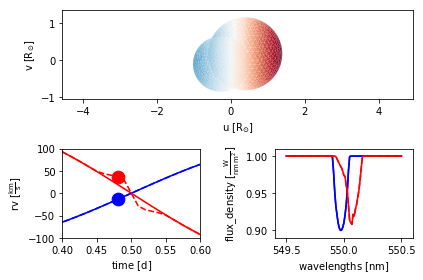

In [13]:
afig, mplfig= b.plot(time=0.48,
                     fc='rvs@numericalrvs', ec='none',
                     show=True,
                     c={'primary': 'blue', 'secondary': 'red'},
                     ls={'numericalrvs': 'dashed', 'dynamicalrvs': 'solid'},
                     highlight={'numericalrvs': True, 'dynamicalrvs': False},
                     tight_layout=True,
                     axpos={'mesh': 211, 'rv': 223, 'lp': 224},
                     xlim={'rv': (0.4, 0.6)}, ylim={'rv': (-100, 100)})

Here we can see that the blue part of the back star is eclipsed, distorting the line profile, and causing the apparent center of the line profile to be shifted to the right/red.

Now let's animate the same figure in time.

/home/kyle/.local/lib/python2.7/site-packages/phoebe/parameters/parameters.py:3177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif current_value in ['time', 'times'] and 'residuals' in kwargs.values():


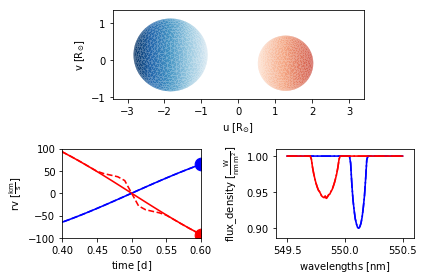

In [14]:
afig, mplanim = b.plot(times=anim_times,
                       fc='rvs@numericalrvs', ec='none',
                       animate=True, save='rossiter_mclaughlin.gif',
                       save_kwargs={'writer': 'imagemagick'},
                       c={'primary': 'blue', 'secondary': 'red'},
                       ls={'numericalrvs': 'dashed', 'dynamicalrvs': 'solid'},
                       highlight={'numericalrvs': True, 'dynamicalrvs': False},
                       tight_layout=True, pad_aspect=False,
                       axpos={'mesh': 211, 'rv': 223, 'lp': 224},
                       xlim={'rv': (0.4, 0.6)}, ylim={'rv': (-100, 100)})

![rm animation](rossiter_mclaughlin.gif)